In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, ReLU, Add, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import cv2
import imutils
import matplotlib.pyplot as plt
import time
from os import listdir
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.utils import to_categorical


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" director
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

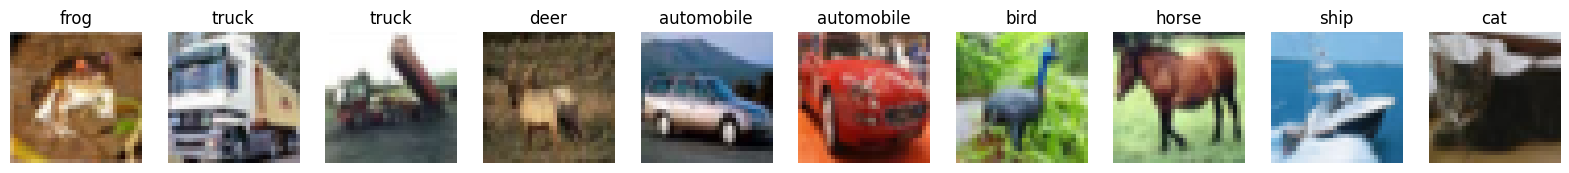

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'data\cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [7]:
train_images.shape

(10000, 32, 32, 3)

There are 10000 samples in 1st batch

## Combine all 5 training batches

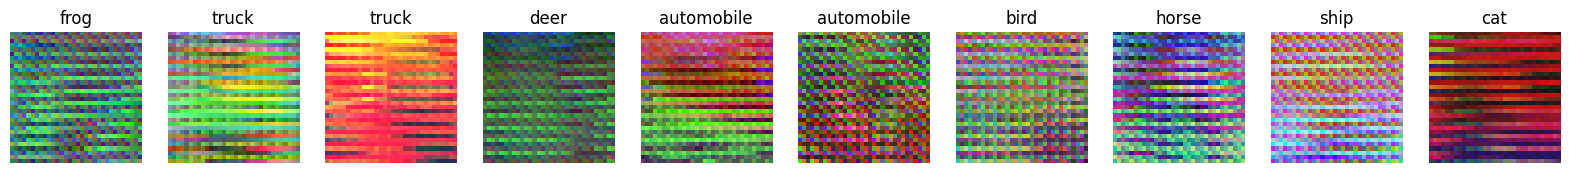

In [8]:
import os
import pickle
import numpy as np

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch_dict = pickle.load(fo, encoding='bytes')
    return batch_dict[b'data'], batch_dict[b'labels']

cifar10_dir = 'data\cifar-10-batches-py'

# Load metadata
with open(os.path.join(cifar10_dir, 'batches.meta'), 'rb') as fo:
    meta_data_dict = pickle.load(fo, encoding='bytes')
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# Initialize lists
all_images = []
all_labels = []

# Corrected loading loop
for file in os.listdir(cifar10_dir):
    if 'data_batch' in file:
        file_path = os.path.join(cifar10_dir, file)
        images, labels = load_cifar_batch(file_path)
        all_images.append(images)
        all_labels.extend(labels)

# Convert and reshape properly
all_images = np.vstack(all_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
all_labels = np.array(all_labels)

# Reshape images to (50000, 32, 32, 3)
all_images = all_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(all_images[i])
    plt.title(label_names[all_labels[i]])
    plt.axis('off')
plt.show()


In [9]:
all_images.shape

(50000, 32, 32, 3)

There are 50000 images/ samples in the dataset and each of them are 32 x 32 pixel RGB image

In [10]:
all_labels.shape

(50000,)

In [11]:
unique_labels, counts = np.unique(all_labels, return_counts=True)
label_counts = dict(zip(unique_labels, counts))

print(label_counts)

{np.int64(0): np.int64(5000), np.int64(1): np.int64(5000), np.int64(2): np.int64(5000), np.int64(3): np.int64(5000), np.int64(4): np.int64(5000), np.int64(5): np.int64(5000), np.int64(6): np.int64(5000), np.int64(7): np.int64(5000), np.int64(8): np.int64(5000), np.int64(9): np.int64(5000)}


In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

all_labels = to_categorical(all_labels, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


Every class has equal number of samples, therefore, it is a balanced dataset

# Pre-Processing the Dataset
### 1. Normalize Pixel Values (Feature Scaling)

In [12]:
all_images = all_images.astype('float32') / 255.0  # Normalize to range [0, 1]

### Standardize the dataset (mean = 0, std = 1):

In [13]:
mean = np.mean(all_images, axis=(0,1,2))  # Compute mean per channel
std = np.std(all_images, axis=(0,1,2))  # Compute std per channel
all_images = (all_images - mean) / std  # Standardize

In [14]:
all_labels = to_categorical(all_labels, num_classes=10)

# Data Augmentation

In [15]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,   
    brightness_range=[0.8, 1.2],  
    zoom_range=0.2        
)

datagen.fit(all_images)  # Fit the generator to dataset
'''

'\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndatagen = ImageDataGenerator(\n    rotation_range=15,      \n    width_shift_range=0.1,  \n    height_shift_range=0.1, \n    horizontal_flip=True,   \n    brightness_range=[0.8, 1.2],  \n    zoom_range=0.2        \n)\n\ndatagen.fit(all_images)  # Fit the generator to dataset\n'

In [16]:
'''
augmented_images, _ = next(datagen.flow(all_images, all_labels, batch_size=10))

# Display the augmented images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()
'''

"\naugmented_images, _ = next(datagen.flow(all_images, all_labels, batch_size=10))\n\n# Display the augmented images\nplt.figure(figsize=(10, 5))\nfor i in range(10):\n    plt.subplot(2, 5, i+1)\n    plt.imshow(augmented_images[i])\n    plt.axis('off')\nplt.show()\n"

# Splitting the Data into train and validation set

Let's use the following way to split:

70% of the data for training. 30% of the data for validation

In [17]:
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.3, random_state = 42)

In [18]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))

number of training examples = 35000
number of validation examples = 15000
X_train shape: (35000, 32, 32, 3)
Y_train shape: (35000, 10)
X_val (dev) shape: (15000, 32, 32, 3)
Y_val (dev) shape: (15000, 10)


# Build a ResNet Model
Model Architecture

In [19]:
# Define Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, shortcut_kernel=1, stride=1, use_se=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, shortcut_kernel, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # Squeeze and Excitation (SE) block
        self.use_se = use_se
        if self.use_se:
            self.se = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(out_channels, out_channels // 16, 1),
                nn.ReLU(),
                nn.Conv2d(out_channels // 16, out_channels, 1),
                nn.Sigmoid()
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.use_se:
            se_weight = self.se(out)
            out = out * se_weight

        out += identity
        return self.relu(out)


# Define ResNet Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers configuration
        self.layers = self._make_layer([64, 128, 256], [[4, 4], [3, 4], [3]], kernel_sizes=[3, 3, 3])
        
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(8)

        # Fully connected layer
        self.fc = nn.Linear(256 * 8 * 8, num_classes)

    def _make_layer(self, channels, num_blocks, kernel_sizes):
        layers = []
        for i, (out_channels, blocks) in enumerate(zip(channels, num_blocks)):
            for _ in range(blocks[0]):  # Residual block counts
                layers.append(ResidualBlock(self.in_channels, out_channels, kernel_size=kernel_sizes[i]))
                self.in_channels = out_channels  # Ensure consistent input channel size
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layers(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet(num_classes=10).to(device)

# Optimizer and Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=130)  # CosineAnnealingLR

# Loss function
criterion = nn.CrossEntropyLoss()

# Print model summary
print(model)

CustomResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (se): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d

In [20]:
#model = Model(inputs=base_model.input, outputs=output)

In [21]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔹 Total Parameters: {total_params:,}")
print(f"🔹 Trainable Parameters: {trainable_params:,}")

🔹 Total Parameters: 4,597,282
🔹 Trainable Parameters: 4,597,282


In [22]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)  # Convert one-hot labels to integers
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Train the model

In [ ]:
# Set up the training loop
epochs = 130
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure the input tensor is in the correct shape
        inputs = inputs.permute(0, 3, 1, 2)  # Reorder to (batch_size, 3, 32, 32)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        acc = correct / labels.size(0)

        running_loss += loss.item()
        running_acc += acc

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)

    # Validation step
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure the input tensor is in the correct shape
            inputs = inputs.permute(0, 3, 1, 2)  # Reorder to (batch_size, 3, 32, 32)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            acc = correct / labels.size(0)

            val_loss += loss.item()
            val_acc += acc

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    # Print the metrics for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Adjust the learning rate using the scheduler
    scheduler.step()


# Model Checkpoints (Optional):

In [ ]:
# Save checkpoint after each epoch
torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

# Test Data

In [ ]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

In [ ]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Pre-Process the test data

In [ ]:
images.shape

In [ ]:
images = images.astype('float32') / 255.0  # Normalize to range [0, 1]

In [ ]:
mean = np.mean(images, axis=(0,1,2))  # Compute mean per channel
std = np.std(images, axis=(0,1,2))  # Compute std per channel
images = (images - mean) / std  # Standardize


In [ ]:
# Convert test dataset to Tensor
test_tensor = torch.tensor(images, dtype=torch.float32)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=False)

In [ ]:
# Generate submission file
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

print(predictions)

In [ ]:
submission = pd.DataFrame({
    'ID': np.arange(len(predictions)),
    'Labels': predictions
})

In [ ]:
submission.to_csv('submission1.csv', index=False)